Mean character count: 54.86
Median character count: 53.00
Standard deviation (chars): 17.07
25th, 50th, 75th, 90th, 95th percentiles (chars): [42.  53.  66.  76.8 81.9]
IQR (chars): 24.00

Mean token count: 15.30
Median token count: 15.00
Standard deviation (tokens): 4.28
25th, 50th, 75th, 90th, 95th percentiles (tokens): [12. 15. 18. 21. 23.]
IQR (tokens): 6.00



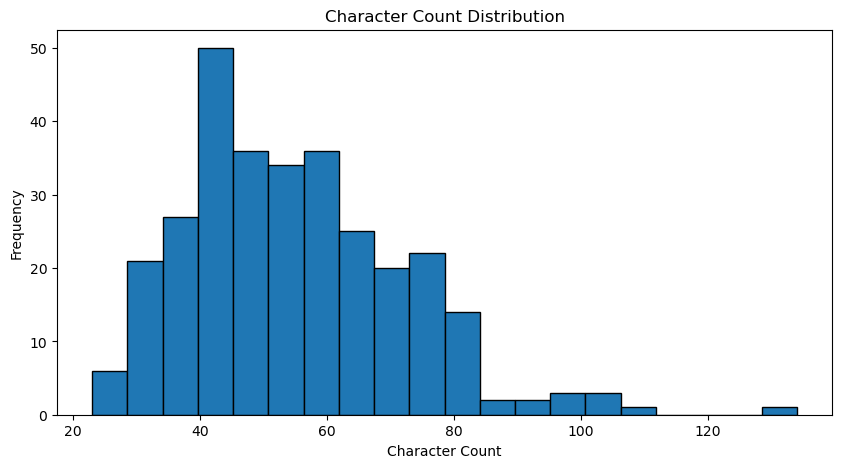

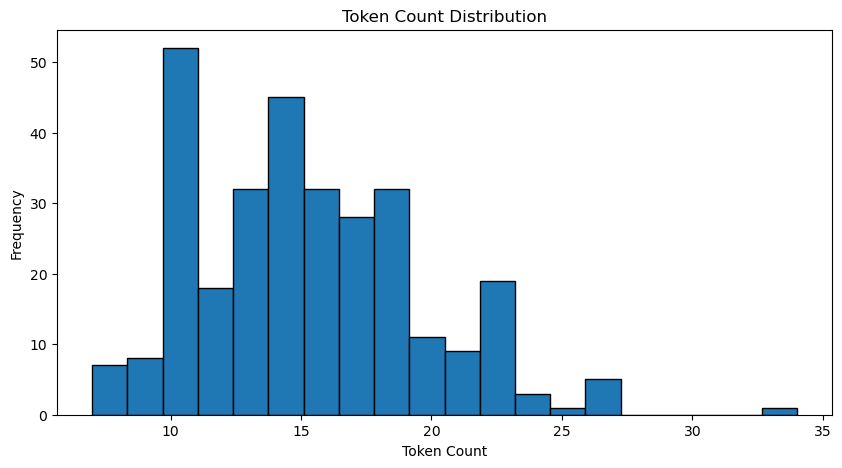

Character Count Histogram Data
 23.0 -  28.6: 6
 28.6 -  34.1: 21
 34.1 -  39.6: 27
 39.6 -  45.2: 50
 45.2 -  50.8: 36
 50.8 -  56.3: 34
 56.3 -  61.9: 36
 61.9 -  67.4: 25
 67.4 -  72.9: 20
 72.9 -  78.5: 22
 78.5 -  84.0: 14
 84.0 -  89.6: 2
 89.6 -  95.1: 2
 95.1 - 100.7: 3
100.7 - 106.2: 3
106.2 - 111.8: 1
111.8 - 117.3: 0
117.3 - 122.9: 0
122.9 - 128.4: 0
128.4 - 134.0: 1
Token Count Histogram Data
  7.0 -   8.3: 7
  8.3 -   9.7: 8
  9.7 -  11.1: 52
 11.1 -  12.4: 18
 12.4 -  13.8: 32
 13.8 -  15.1: 45
 15.1 -  16.5: 32
 16.5 -  17.8: 28
 17.8 -  19.1: 32
 19.1 -  20.5: 11
 20.5 -  21.9: 9
 21.9 -  23.2: 19
 23.2 -  24.6: 3
 24.6 -  25.9: 1
 25.9 -  27.2: 5
 27.2 -  28.6: 0
 28.6 -  30.0: 0
 30.0 -  31.3: 0
 31.3 -  32.7: 0
 32.7 -  34.0: 1


In [4]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
import statistics

def traverse_category(element, parent_path, ns):
    name = element.get("name") or "Unnamed"
    current_path = f"{parent_path} > {name}" if parent_path else name
    children = element.findall("ns:category", ns)
    # Only return the current path if there are no child categories
    if not children:
        return [current_path]
    texts = []
    for child in children:
        texts.extend(traverse_category(child, current_path, ns))
    return texts

# Parse XML file
xml_file = "../../data/pipeline2/xml/OEKOBAU.DAT_Categories.xml"
ns = {"ns": "http://lca.jrc.it/ILCD/Categories"}
tree = ET.parse(xml_file)
root = tree.getroot()
categories_elem = root.find("ns:categories", ns)
texts = []
if categories_elem is not None:
    for cat in categories_elem.findall("ns:category", ns):
        texts.extend(traverse_category(cat, "", ns))
else:
    print("No categories found.")

# print(texts)

# Calculate character and token counts
lengths = [len(text) for text in texts]
enc = tiktoken.get_encoding("o200k_base")
token_counts = [len(enc.encode(text)) for text in texts]

# Basic measures: Mean
mean_length = statistics.mean(lengths) if lengths else 0
mean_tokens = statistics.mean(token_counts) if token_counts else 0

# Additional measures: Median, Standard Deviation, Percentiles, IQR
median_length = np.median(lengths) if lengths else 0
median_tokens = np.median(token_counts) if token_counts else 0

std_length = np.std(lengths, ddof=1) if len(lengths) > 1 else 0
std_tokens = np.std(token_counts, ddof=1) if len(token_counts) > 1 else 0

percentiles_length = np.percentile(lengths, [25, 50, 75, 90, 95]) if lengths else [0]*5
percentiles_tokens = np.percentile(token_counts, [25, 50, 75, 90, 95]) if token_counts else [0]*5

iqr_length = percentiles_length[2] - percentiles_length[0]
iqr_tokens = percentiles_tokens[2] - percentiles_tokens[0]

# Print statistical measures
print(f"Mean character count: {mean_length:.2f}")
print(f"Median character count: {median_length:.2f}")
print(f"Standard deviation (chars): {std_length:.2f}")
print(f"25th, 50th, 75th, 90th, 95th percentiles (chars): {percentiles_length}")
print(f"IQR (chars): {iqr_length:.2f}\n")

print(f"Mean token count: {mean_tokens:.2f}")
print(f"Median token count: {median_tokens:.2f}")
print(f"Standard deviation (tokens): {std_tokens:.2f}")
print(f"25th, 50th, 75th, 90th, 95th percentiles (tokens): {percentiles_tokens}")
print(f"IQR (tokens): {iqr_tokens:.2f}\n")

# Plot histograms for visual inspection
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=20, edgecolor="black")
plt.title("Character Count Distribution")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(token_counts, bins=20, edgecolor="black")
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

# Print histogram data in numeric format
def print_histogram_data(data, bins=20, title="Histogram"):
    counts, bin_edges = np.histogram(data, bins=bins)
    print(title)
    for i in range(len(counts)):
        lower = bin_edges[i]
        upper = bin_edges[i+1]
        print(f"{lower:5.1f} - {upper:5.1f}: {counts[i]}")

print_histogram_data(lengths, bins=20, title="Character Count Histogram Data")
print_histogram_data(token_counts, bins=20, title="Token Count Histogram Data")


In [2]:
import os
import gc
import torch
import xml.etree.ElementTree as ET
from typing import List
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_ollama import OllamaEmbeddings
from langchain.embeddings.base import Embeddings


class CustomSentenceTransformerEmbeddings(Embeddings):
    """
    Allows using a SentenceTransformer model within a LangChain-based FAISS store.
    Handles initialization of different models with specific arguments.
    """

    def __init__(self, embedding_model_name: str):
        self.embedding_model_name = embedding_model_name
        self.model = self._initialize_model()

    def _initialize_model(self) -> SentenceTransformer:
        """
        Initializes the SentenceTransformer model based on the embedding_model_name.
        """
        # Define initialization configurations for each model
        model_configs = {
            "jinaai/jina-embeddings-v3": {
                "trust_remote_code": True,
                "revision": "main",
                "device": "cuda",
                "model_kwargs": {"use_flash_attn": False},
            },
            "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5": {
                "local_files_only": True,
                "device": "cuda",
                "model_kwargs": {"attn_implementation": "eager"},
            },
            "Alibaba-NLP/gte-large-en-v1.5": {
                "trust_remote_code": True,
                "revision": "main",
                "device": "cuda",
                "model_kwargs": {"attn_implementation": "eager"},
            },
        }

        config = model_configs.get(
            self.embedding_model_name,
            {"device": "cuda", "model_kwargs": {}},  # Default device
        )

        try:
            model = SentenceTransformer(self.embedding_model_name, **config)
            print(f"Initialized SentenceTransformer model: {self.embedding_model_name}")
            return model
        except Exception as e:
            print(f"Error initializing model {self.embedding_model_name}: {e}")
            raise

    def embed_query(self, text: str) -> List[float]:
        return self.model.encode(text).tolist()

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return self.model.encode(texts).tolist()

    def unload_model(self):
        """
        Remove the model from memory after processing to free up GPU resources.
        """
        if self.model:
            del self.model  # Delete the model instance
            self.model = None  # Ensure the reference is cleared
            torch.cuda.empty_cache()  # Clear the GPU cache
            gc.collect()  # Run garbage collection
            print(f"Unloaded embedding model: {self.embedding_model_name}")
        else:
            print("[DEBUG] Embedding model was already None or not set.")


def get_documents_from_xml(xml_path: str) -> List[Document]:
    ns = {"ns": "http://lca.jrc.it/ILCD/Categories"}
    tree = ET.parse(xml_path)
    root = tree.getroot()
    categories_elem = root.find("ns:categories", ns)
    documents = []
    if categories_elem is None:
        print("No categories found in the XML file.")
        return documents
    for cat in categories_elem.findall("ns:category", ns):
        documents.extend(traverse_leaf_category(cat, "", ns))
    return documents


def traverse_leaf_category(element, parent_path, ns) -> List[Document]:
    name = element.get("name") or "Unnamed"
    current_path = f"{parent_path} > {name}" if parent_path else name
    children = element.findall("ns:category", ns)
    if children:
        docs = []
        for child in children:
            docs.extend(traverse_leaf_category(child, current_path, ns))
        return docs
    else:
        parts = current_path.split(" > ")
        metadata = {}
        if len(parts) >= 1:
            metadata["h1"] = parts[0]
        if len(parts) >= 2:
            metadata["h2"] = parts[1]
        return [Document(page_content=current_path, metadata=metadata)]


def save_chunks(chunks: List[Document], output_file: str):
    with open(output_file, "w", encoding="utf-8") as f:
        for i, chunk in enumerate(chunks):
            f.write(
                f"Chunk {i+1}:\n{chunk.page_content}\nMetadata: {chunk.metadata}\n{'-'*50}\n"
            )
    print(f"Chunks saved to {output_file}")


def process_vectorstore(
    chunks: List[Document],
    model: str,
    vectorstore_path: str,
    chunk_size: int = 150,
):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=0
    )
    all_splits = text_splitter.split_documents(chunks)

    # Load the embedding model
    if model in [
        "jinaai/jina-embeddings-v3",
        "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5",
        "Alibaba-NLP/gte-large-en-v1.5",
    ]:
        embeddings = CustomSentenceTransformerEmbeddings(
            embedding_model_name=model,
        )
    else:
        embeddings = OllamaEmbeddings(model=model)
        print(f"Initialized Ollama embedding model: {model}")

    vectorstore = FAISS.from_documents(
        all_splits,
        embedding=embeddings,
        distance_strategy=DistanceStrategy.COSINE,
    )
    vectorstore.save_local(vectorstore_path)
    print(f"Vector store saved to {vectorstore_path}")

    if isinstance(embeddings, CustomSentenceTransformerEmbeddings):
        embeddings.unload_model()


#########
# Usage
#########
xml_file = "../../data/pipeline2/xml/OEKOBAU.DAT_Categories.xml"
documents = get_documents_from_xml(xml_file)
chunk_size = 150  # Chosen to cover the maximum token count of a category
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0)
chunks = text_splitter.split_documents(documents)

output_dir = "../../data/pipeline2/chunks"
os.makedirs(output_dir, exist_ok=True)
chunk_file = os.path.join(output_dir, f"chunks_cs{chunk_size}.txt")
save_chunks(chunks, chunk_file)

models = [
    "bge-m3:latest",
    "snowflake-arctic-embed2:latest",
    "jina/jina-embeddings-v2-base-de:latest",
    "paraphrase-multilingual:latest",
    "jeffh/intfloat-multilingual-e5-large-instruct:f32",
    "granite-embedding:278m",
    "bge-large:latest",
    "mxbai-embed-large:latest",
    "jinaai/jina-embeddings-v3",
    "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5",
    "Alibaba-NLP/gte-large-en-v1.5",
]
for model in models:
    if model == "jinaai/jina-embeddings-v3":
        model_name = model.replace("/", "_")
    elif model.startswith("HIT-TMG") or model.startswith("Alibaba-NLP"):
        model_name = model.replace("/", "_")
    elif ":" in model:
        model_name = model.split(":")[0].replace("/", "_")
    else:
        model_name = model.replace("/", "_")
    # chunk_strat = f"row_cs{chunk_size}_co0"
    vectorstore_dir = os.path.join(
        "..", "..", "embeddings", "pipeline2", model_name, f"faiss_index_COS"
    )
    process_vectorstore(
        chunks,
        model,
        vectorstore_dir,
        chunk_size=chunk_size,
    )

Chunks saved to ../../data/pipeline2/chunks\chunks_cs150.txt
Initialized Ollama embedding model: bge-m3:latest
Vector store saved to ..\..\embeddings\pipeline2\bge-m3\faiss_index_COS
Initialized Ollama embedding model: snowflake-arctic-embed2:latest
Vector store saved to ..\..\embeddings\pipeline2\snowflake-arctic-embed2\faiss_index_COS
Initialized Ollama embedding model: jina/jina-embeddings-v2-base-de:latest
Vector store saved to ..\..\embeddings\pipeline2\jina_jina-embeddings-v2-base-de\faiss_index_COS
Initialized Ollama embedding model: paraphrase-multilingual:latest
Vector store saved to ..\..\embeddings\pipeline2\paraphrase-multilingual\faiss_index_COS
Initialized Ollama embedding model: jeffh/intfloat-multilingual-e5-large-instruct:f32
Vector store saved to ..\..\embeddings\pipeline2\jeffh_intfloat-multilingual-e5-large-instruct\faiss_index_COS
Initialized Ollama embedding model: granite-embedding:278m
Vector store saved to ..\..\embeddings\pipeline2\granite-embedding\faiss_inde

In [5]:
texts

['Mineralische Baustoffe > Bindemittel > Zement',
 'Mineralische Baustoffe > Bindemittel > Kalk',
 'Mineralische Baustoffe > Bindemittel > Gips',
 'Mineralische Baustoffe > Bindemittel > Lehm',
 'Mineralische Baustoffe > Zuschläge > Sand und Kies',
 'Mineralische Baustoffe > Zuschläge > Naturstein',
 'Mineralische Baustoffe > Zuschläge > Bims',
 'Mineralische Baustoffe > Zuschläge > Blähton',
 'Mineralische Baustoffe > Zuschläge > Blähschiefer',
 'Mineralische Baustoffe > Zuschläge > Blähglas',
 'Mineralische Baustoffe > Zuschläge > Perlite',
 'Mineralische Baustoffe > Zuschläge > Kraftwerksnebenprodukte',
 'Mineralische Baustoffe > Zuschläge > Puzzolan',
 'Mineralische Baustoffe > Zuschläge > Trockenschüttung',
 'Mineralische Baustoffe > Steine und Elemente > Kalksandstein',
 'Mineralische Baustoffe > Steine und Elemente > Ziegel',
 'Mineralische Baustoffe > Steine und Elemente > Porenbeton',
 'Mineralische Baustoffe > Steine und Elemente > Leichtbeton',
 'Mineralische Baustoffe > Ste